<a href="https://colab.research.google.com/github/pedrohortencio/Digit-Recognizer-SVC-Kaggle/blob/master/Digit_Recognizer_SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Pesquisa sobre o dataset MNIST](http://yann.lecun.com/exdb/mnist/)

Inclui índices de erro de diversos tipos de algoritmo. O SVC que usei aqui é baseado na radial basis function (rbf). É possível utilizar o kernel polinomial, com grau 9, para melhores resultados, como mostrado no link.

[Competição do Kaggle](https://www.kaggle.com/c/digit-recognizer)

##Importação de Módulos e Transferência de Arquivos

###Importação de pacotes

In [46]:
import numpy as np                  
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Criação e validação do token da API do Kaggle, para que os pacotes possam ser baixados. É necessário que o arquivo kaggle.jason esteja na pasta /content do Google Colab. As duas células de código abaixo devem ser alteradas a depender do sistema onde o código está sendo executado. Caso os arquivos estejam salvos localmente, não é necessário que elas sejam executadas.

In [2]:
!pip install -q kaggle

In [3]:
#mudança do diretório onde fica salvo o kaggle.jason
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


###Download dos pacotes

In [4]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 89.4MB/s]
 82% 5.00M/6.09M [00:01<00:00, 3.42MB/s]
100% 6.09M/6.09M [00:01<00:00, 4.07MB/s]
 98% 9.00M/9.16M [00:00<00:00, 92.8MB/s]
100% 9.16M/9.16M [00:00<00:00, 84.4MB/s]


##Criação dos DataFrames

In [59]:
# importação dos dataframes da pasta /content, onde estão os arquivos baixados
df_treino = pd.read_csv('/content/train.csv.zip', compression='zip', 
                        header=0, sep=',', quotechar='"')
df_teste = pd.read_csv('/content/test.csv.zip', compression='zip', 
                       header=0, sep=',', quotechar='"')

In [60]:
df_treino.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
df_teste.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
# Formato dos arquivos
print(df_treino.shape)
print(df_teste.shape)

(42000, 785)
(28000, 784)


In [63]:
# Criando um ndarray de labels que será usada para avaliação
y = df_treino['label'].to_numpy()

# Retirando a coluna de labels do DataFrame
df_treino = df_treino.drop('label', axis=1)

In [64]:
# Transformando o dataset com informações das imagens em um ndarray, para ser mais fácil printar as imagens
X_visu = df_treino.to_numpy()
X_visu

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [65]:
X_visu.shape

(42000, 784)

## Visualização do dataset

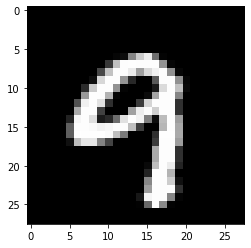

In [66]:
# Cada um dos 42000 arrays possui uma dimensão, de 784 posições.
    # para ser transformado em imagem, precisa ser convertido em formato 2D.
    # a conversão é feita usando a função .reshape(x, y)
plt.imshow(X_visu[9238].reshape(28,28), cmap='gray')

Visualização em Grid

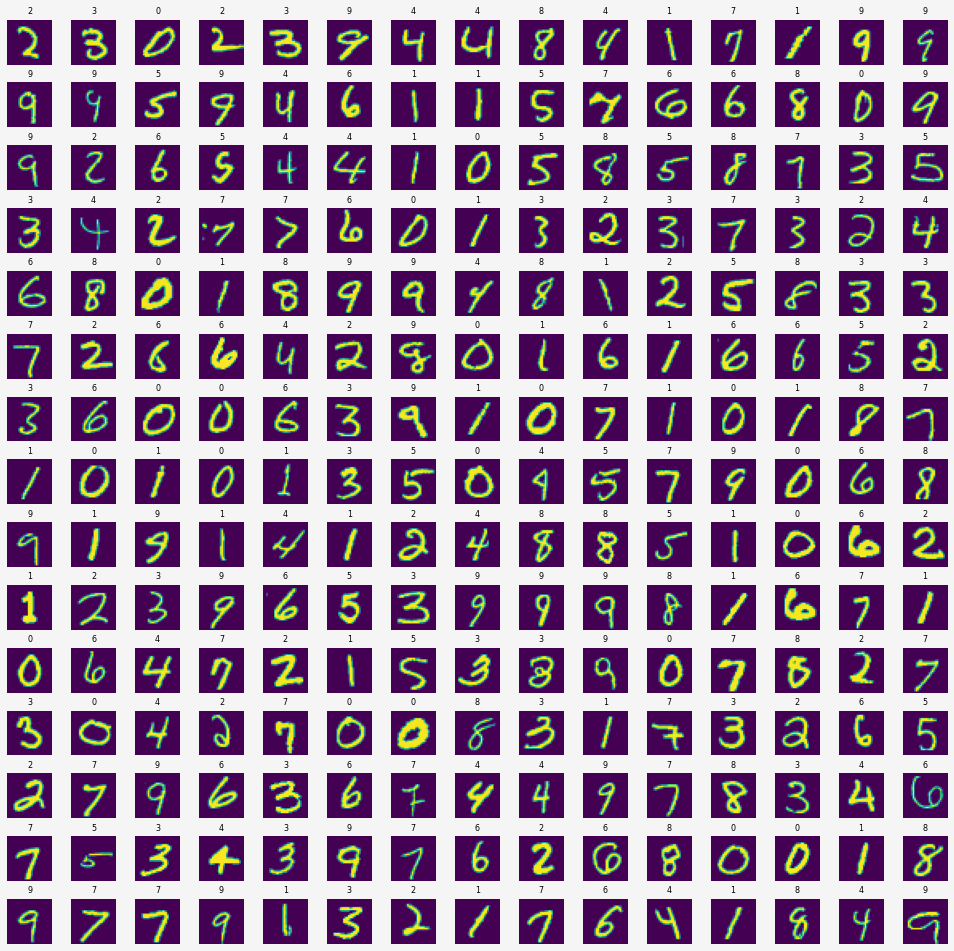

In [67]:
# Definindo o tamanho do grid (altura e largura)
W_grid = 15
L_grid = 15

# Criando os objetos figure e axes (eixos), que são retornados pela função subplot
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

# Mudando a cor do background
fig.patch.set_facecolor('whitesmoke')

# Achatando a matrix 15 x 15 em um array de 255 posições
axes = axes.ravel()

n_training = len(X_visu) # Retorna o tamanho do ndarray X_visu (qtd de imagens)

# Selecionando um número aleatório entre 0 e n_training
for i in np.arange(0, W_grid * L_grid): # Cria variáveis igualmente espaçadas 

    # Selecionando outro número aleatório
    index = np.random.randint(0, n_training)
    # Lendo e exibindo a imagem no índice escolhido aleatoriamente    
    axes[i].imshow(X_visu[index].reshape(28,28))
    axes[i].set_title(y[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

##Usando Principal Component Analysis (PCA) para reduzir as dimensões (colunas) do dataset. Isso será feito para normalizar os dados e, mais importante, retirar redundâncias e tornar o processo de aprendizado mais rápido.

In [68]:
print(y.shape)
print(df_treino.shape)

(42000,)
(42000, 784)


##Criando um scaler (que será usado para normalizar os dados antes de alimentar o PCA).

In [69]:
scaler = MinMaxScaler()

In [70]:
# Fazendo o fit do scaler e transformando os dados do dataframe
data_rescaled = scaler.fit_transform(df_treino)

In [71]:
df_treino.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Criando e treinando o PCA.

[PCA - How to choose the number of components](https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/)

In [72]:
# o número de componentes foi fixado em 154 por corresponder a uma taxa de 
    # 95% de variância dos dados. Mais detalhes podem ser lidos no link em anexo.
# o svd_solver foi fixado em randomized por ser apropriado para grandes datasets e
    # para permitir que o random_state seja fixado, fazendo com que o PCA tenha
        # o mesmo comportamento em múltiplas chamadas
pca = PCA(n_components = 154, svd_solver='randomized', random_state=0)

In [73]:
# Treinando o modelo no dataset normalizado
pca.fit(data_rescaled)

PCA(copy=True, iterated_power='auto', n_components=154, random_state=0,
    svd_solver='randomized', tol=0.0, whiten=False)

In [74]:
X = pca.transform(data_rescaled)

In [75]:
X.shape

(42000, 154)

In [76]:
X

array([[-2.59449322, -2.74239731,  0.71875289, ...,  0.0548488 ,
        -0.10261584,  0.06860951],
       [ 6.67235952, -1.41392745, -1.96786508, ..., -0.1402549 ,
         0.17814568,  0.26889766],
       [-3.47801736, -1.15202264,  0.2633542 , ..., -0.04495998,
         0.03037539, -0.01087953],
       ...,
       [ 1.31870578,  3.72555025, -0.66119799, ...,  0.18502275,
        -0.02308405, -0.14164991],
       [ 1.28391919,  0.24320023,  2.7354372 , ..., -0.09183229,
        -0.15411782, -0.0466859 ],
       [-1.42842822,  1.64271767,  0.24666594, ...,  0.25207376,
        -0.03937692,  0.35087938]])

In [77]:
y

array([1, 0, 1, ..., 7, 6, 9])

##Criação dos dados de treino e validação (dados de teste serão o dataset separado).

In [78]:
(X_train, X_validation,
 y_train, y_validation) = train_test_split(X, y, random_state=0)

##Treino do modelo SVC.
[Documentação SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [79]:
# Criação do modelo.
    # C = parâmetro de regularização
    # cache_size = tamanho do cache em MB
    # decision_function_shape = ativa o movo one_vs_one, para uma classificação
        #multiclass (há 10 possíveis classes de label)
svc_model = SVC(C=3, cache_size=4000, decision_function_shape='ovo')

[Documentação GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Atenção: GridSearch é uma ótima ferramenta para buscar a melhor combinação de parâmetros de um determinado modelo de machine learning do sklearn, porém quando se trabalha com datasets grandes a sua execução é lenta. Usar PCA e, no caso do SVC, aumentar o ```cache_size``` diminuem o tempo de execução, mas aconselho cautela na criação do dicionário que o GridSearch utiliza para fazer as combinações. É criado um modelo para cada combinação.

In [80]:
# Os parâmetros foram escolhidos usando GridSearch. O código está abaixo:

#from sklearn.model_selection import GridSearchCV

# Os parâmetros são colocados aqui. O dict com list têm os valores a serem testados

#parameter = [{'C':[1, 3, 5, 10, 50],
#              'cache_size':[4000],
#              'decision_function_shape':['ovo']}]

#classifier = GridSearchCV(SVC(), parameter, scoring='accuracy')
#classifier.fit(X_train, y_train)

# Exibe os melhores parâmetros encontrados
#print(classifier.best_params_)

# Exibe a melhor pontuação (obviamente advinda dos melhores parâmetros)
#print(classifier.best_score_)

In [81]:
# Treinando o modelo
svc_model.fit(X_train, y_train)

SVC(C=3, break_ties=False, cache_size=4000, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [82]:
# Guardando as predições para o dataset X_validation numa variável
yhat_validation = svc_model.predict(X_validation)

In [83]:
# Avaliação do modelo quanto à sua acurácia
accuracy_score(yhat_validation, y_validation)

0.9821904761904762

##Realizando a predição no dataset de teste e gerando o arquivo .csv para o Kaggle

In [84]:
# Normalizando os dados do dataframe de teste
data_rescaled2 = scaler.transform(df_teste)

In [85]:
# Utilizando o modelo PCA para realizar a redução de dimensões
X_teste = pca.transform(data_rescaled2)

In [86]:
X_teste.shape

(28000, 154)

In [87]:
# Executando o modelo SVC no dataset de treino
result = svc_model.predict(X_teste)

In [88]:
# Criando um dataframe com as predições
df = pd.DataFrame(result)

# Incrementando o índice em 1 para estar no padrão de ID do Kaggle
df.index+=1

In [89]:
print(result.shape)

# Criando o arquivo. Ele será salvo na pasta /content, podendo ser baixado.
filename = 'DigitalPredictions.csv'
df.to_csv(filename,index=True,header=["Label"],index_label=["ImageId"])
print('Saved file: ' + filename)

(28000,)
Saved file: DigitalPredictions.csv
